In [62]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras import models
from keras import layers
import pickle
import matplotlib.pyplot as plt

In [6]:
input_folder_path='../input_data/'
output_folder_path = '../trained_model/'
input_file_name = 'movies_metadata.csv'

# 1. Data preparation

## 1.1 Reading movies data

We import the csv file with the movies information.

In [7]:
movies = pd.read_csv(input_folder_path+input_file_name, 
                     usecols= ['id','title', 'overview', 'genres'],
                     dtype={"id": str, "title": str, "overview": str},
                     converters={"genres": literal_eval})

In [8]:
movies.shape

(45466, 4)

## 1.2 Filtering

We remove useless rows:
- with tile value missing
- with overview value too short
- with an empty genres list

In [12]:
movies = movies[movies.title.notna()]

In [13]:
movies = movies[movies.overview.str.len()>50]

In [14]:
movies = movies[movies.genres.apply(len)>0]

In [15]:
movies.shape

(41910, 4)

## 1.3 Chosing an unique genre

The movies dataset has, for each movie, a list of genres with length between 1 and 3. There are 20 different genres.

In [16]:
all_genres = [element for list_ in movies.genres for element in list_]

In [17]:
genres_freq = dict(Counter([element["name"] for element in all_genres]).most_common())

In [18]:
len(genres_freq)

20

In [19]:
genres_freq

{'Drama': 19889,
 'Comedy': 12652,
 'Thriller': 7543,
 'Romance': 6638,
 'Action': 6526,
 'Horror': 4625,
 'Crime': 4249,
 'Documentary': 3824,
 'Adventure': 3458,
 'Science Fiction': 3007,
 'Family': 2712,
 'Mystery': 2445,
 'Fantasy': 2275,
 'Animation': 1896,
 'Foreign': 1579,
 'Music': 1566,
 'History': 1375,
 'War': 1306,
 'Western': 1027,
 'TV Movie': 744}

In scope of this project, we want to reduce the number of possible genres to `num_of_genres=10`, removing the less common ones.
So we define a subset of genre values as the 10 most common and we filter out, for each movie, the genres not included in this short list.

In [20]:
genres_list = list(genres_freq.keys())

In [21]:
num_of_genres=10

In [22]:
genres_subset = genres_list[:num_of_genres]

In [23]:
genres_subset

['Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Horror',
 'Crime',
 'Documentary',
 'Adventure',
 'Science Fiction']

In [24]:
movies['accepted_genres'] = movies.genres.apply(
    lambda x: list(set([elem_["name"] for elem_ in x ])\
                  .intersection(set(genres_subset))))

We now have some movies for which, because this filtering, there is no genre associated. We remove them and we create a new dataframe `movies_reduced`.

In [28]:
movies[movies.accepted_genres.apply(len)==0].shape, movies.shape

((1429, 5), (41910, 5))

In [29]:
movies_reduced = movies[movies.accepted_genres.apply(len)>0].copy()

Finally, we want to have just one genre per movie, so we define the column `unique genre` as the first genre of the list.

In [31]:
movies_reduced['unique_genre'] = movies_reduced.accepted_genres.apply(lambda x: x[0])

In [32]:
movies_reduced.head(3)

,genres,id,overview,title,accepted_genres,unique_genre
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story,[Comedy],Comedy
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji,[Adventure],Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men,"[Romance, Comedy]",Romance


In [33]:
movies_reduced.shape

(40481, 6)

In [77]:
movies_reduced.loc[1].overview

"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures."

We finally have our data set ready!

## 1.4 Vectorization

Overview values are strings, we want to tokenize them before they are input in the model. We set a vocabulary length `num_words=10000` to consider only the most common words.

In [36]:
num_words=10000

In [37]:
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)

In [38]:
tokenizer.fit_on_texts(movies_reduced.overview)

In [39]:
len(tokenizer.word_index)

81888

In [41]:
tokenized_overviews = tokenizer.texts_to_sequences(movies_reduced.overview.str.split())

We transform genre value to the correspondant index of the genres list, creating the genre label

In [42]:
genre_labels = movies_reduced.unique_genre.apply(lambda x: genres_subset.index(x)).tolist()

# 2. The model

## 2.1 Data encoding

We want to one-hot encode both tokenized overviews and genre indexes.

In [46]:
vectorized_overviews = np.zeros((len(tokenized_overviews), num_words), bool)

In [47]:
for i, tokenized_ov in enumerate(tokenized_overviews):
    vectorized_overviews[i, tokenized_ov]=True

In [48]:
vectorized_overviews

array([[False,  True, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False,  True,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False,  True, ..., False, False, False]])

In [50]:
genre_one_hot = to_categorical(genre_labels)

In [51]:
genre_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

## 2.2 Split train test

We can now split the input set in train and test. Part of the train one will be used as validation set.

In [52]:
test_size= 10000

In [54]:
vectorized_overviews_train = vectorized_overviews[:-test_size]

In [55]:
vectorized_overviews_test = vectorized_overviews[-test_size:]

In [56]:
len(vectorized_overviews_train),len(vectorized_overviews_test)

(30481, 10000)

In [57]:
genre_one_hot_train = genre_one_hot[:-test_size]
genre_one_hot_test = genre_one_hot[-test_size:]

In [58]:
len(genre_one_hot_train),len(genre_one_hot_test)

(30481, 10000)

## 2.3 Architecture of the NN

The definition of the architecture of the network is the setting of all the hyperparameters (number of layers, number of nodes, activation functions, ...).

In [61]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(num_words,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_of_genres, activation='softmax'))

## 2.4 Compiling

We define the optimizer, loss function and the evaluation metrics.

In [63]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 2.5 Training

In [64]:
history = model.fit(vectorized_overviews_train,
                    genre_one_hot_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.1)

2021-07-10 17:26:11.798283: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-10 17:26:11.817037: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/10
54/54 [==============================] - 3s 39ms/step - loss: 1.8645 - accuracy: 0.3828 - val_loss: 1.5251 - val_accuracy: 0.4775
Epoch 2/10
54/54 [==============================] - 2s 33ms/step - loss: 1.2275 - accuracy: 0.5862 - val_loss: 1.4528 - val_accuracy: 0.4998
Epoch 3/10
54/54 [==============================] - 3s 65ms/step - loss: 0.9646 - accuracy: 0.6787 - val_loss: 1.4892 - val_accuracy: 0.5005
Epoch 4/10
54/54 [==============================] - 4s 67ms/step - loss: 0.7790 - accuracy: 0.7430 - val_loss: 1.6579 - val_accuracy: 0.4844
Epoch 5/10
54/54 [==============================] - 4s 71ms/step - loss: 0.6189 - accuracy: 0.8046 - val_loss: 1.7814 - val_accuracy: 0.4805
Epoch 6/10
54/54 [==============================] - 4s 69ms/step - loss: 0.4865 - accuracy: 0.8505 - val_loss: 1.8855 - val_accuracy: 0.4624
Epoch 7/10
54/54 [==============================] - 4s 66ms/step - loss: 0.3748 - accuracy: 0.8928 - val_loss: 2.1386 - val_accuracy: 0.4615
Epoch 8/10
54

## 2.6 NN evaluation

We evaluate the NN performance on the training and validation sets, looking both at the loss function and accuracy metrics.

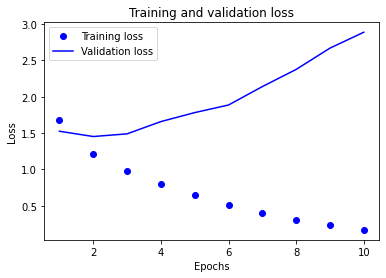

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

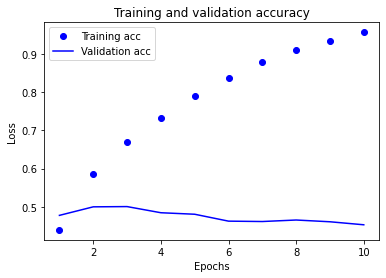

In [66]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Then we evaluate th performance on the test set.

In [67]:
model.evaluate(vectorized_overviews_test, genre_one_hot_test)

313/313 [==============================] - 7s 22ms/step - loss: 2.8709 - accuracy: 0.4562


[2.870879650115967, 0.4562000036239624]

# 3. Saving the outputs

We save the outputs to make them available to the application.

In [74]:
model.save(output_folder_path+'nn/')

INFO:tensorflow:Assets written to: ../trained_model/nn/assets


In [75]:
with open(output_folder_path+'genres_subset.txt', "wb") as fp:
    pickle.dump(genres_subset, fp)

with open(output_folder_path+'tokenizer.txt', "wb") as fp:
    pickle.dump(tokenizer, fp)